# <center>An application of SVM and Neural Network: <br> Bank Marketing Campaigns</center>

<br>
Prepared by: Punloeuvivorth ROM


<br>
This project is built for the assessment for the course of SVM and ANN (M2-ECAP, IAE Nantes) with Mr. Benjamin Roul. The objective is thus to implement the course elements in a machine learning project. 

The dataset used in this project is from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing). The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

The classification goal is thus to predict if the client will subscribe (yes/no) a term deposit (y). The attribute information can be found [here](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

<a id="20"></a>
 ### Table of Contents  
 
1. [Importing data](#1) <br>
2. [Explanatory data analysis (EDA)](#2) <br>
    2.1 [Target variable](#3) <br>
    2.2 [Bank client data](#4) <br>
    2.3 [Last contact information](#5) <br>
    2.4 [Other attributes](#6) <br>
    2.5 [Social and economic context attributes](#7) <br>
    2.6 [Features correlation](#8) <br>  
3. [Data Preprocessing](#9) <br>
    3.1 [Outliers](#10) <br>
    3.2 [Resampling](#11) <br>
    3.3 [Dealing with categorical variables](#12) <br>
    3.4 [Splitting data](#13) <br>
    3.5 [Features scaling](#14) <br> 
4. [Modelling](#15) <br>
    4.1 [Logistic Regression](#16) <br>
    4.2 [SVM Classifier](#17) <br>
    4.3 [ANN](#18) <br>  
5. [Results Summary](#19)

In [23]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

import os
import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_columns', 30)
#pd.reset_option('display.max_columns')

<a id="1"></a>
# 1. Importing data
[Table of contents](#20)

In [3]:
#path = '/Users/punloeuvivorthrom/Works/M2/SVM_ANN/Python/Projet/data'
path = 'C:/Users/ASUS/Desktop/Project/SVM/data'

df = pd.read_csv(path + '/bank-additional-full.csv', sep = ';')
df.shape

(41188, 21)

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Basic summary of the dataset:  
- There are 41188 observations with 20 inputs (ordered by date from May 2008 to November 2010).
- There is no missing values.
- As confirmed with the given data description, the variable 'duration' highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

<a id="2"></a>
# 2. Exploratory data analysis (EDA)
[Table of contents](#20) <br>  
2.1 [Target variable](#3) <br>
2.2 [Bank client data](#4) <br>
2.3 [Last contact information](#5) <br>
2.4 [Other attributes](#6) <br>
2.5 [Social and economic context attributes](#7) <br>
2.6 [Features correlation](#8)

<a id="3"></a>
## 2.1 Target variable

In [117]:
df.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

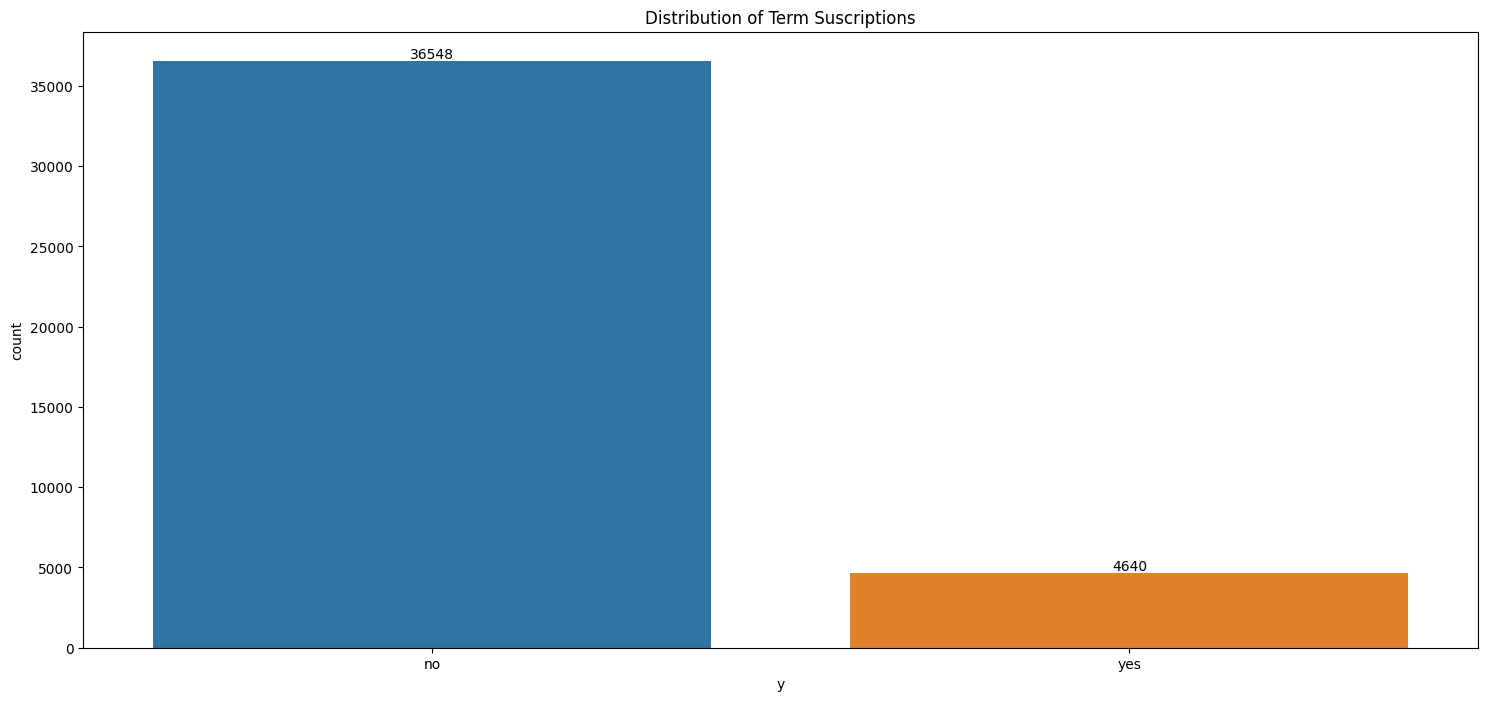

In [118]:
plt.figure(figsize = (18,8))
ax = sns.countplot(x='y', data=df)
ax.set_title("Distribution of Term Suscriptions")
for i in ax.containers:
    ax.bar_label(i,)

The target variable is moderately imbalanced which may cause overfitting as the training model will spend most of its time on negative examples and not learn enough from positive ones. We will deal with this problem later.

<a id="4"></a>
## 2.2 Bank client data
[Table of contents](#20)

In [119]:
df_client = df.iloc[: , 0:7]
df_client.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan'], dtype='object')

In [120]:
df_client.describe()

,age
count,41188.00000
mean,40.02406
std,10.42125
min,17.00000
25%,32.00000
50%,38.00000
75%,47.00000
max,98.00000


### 2.2.1 Personal infomation: age, job , marital status, education

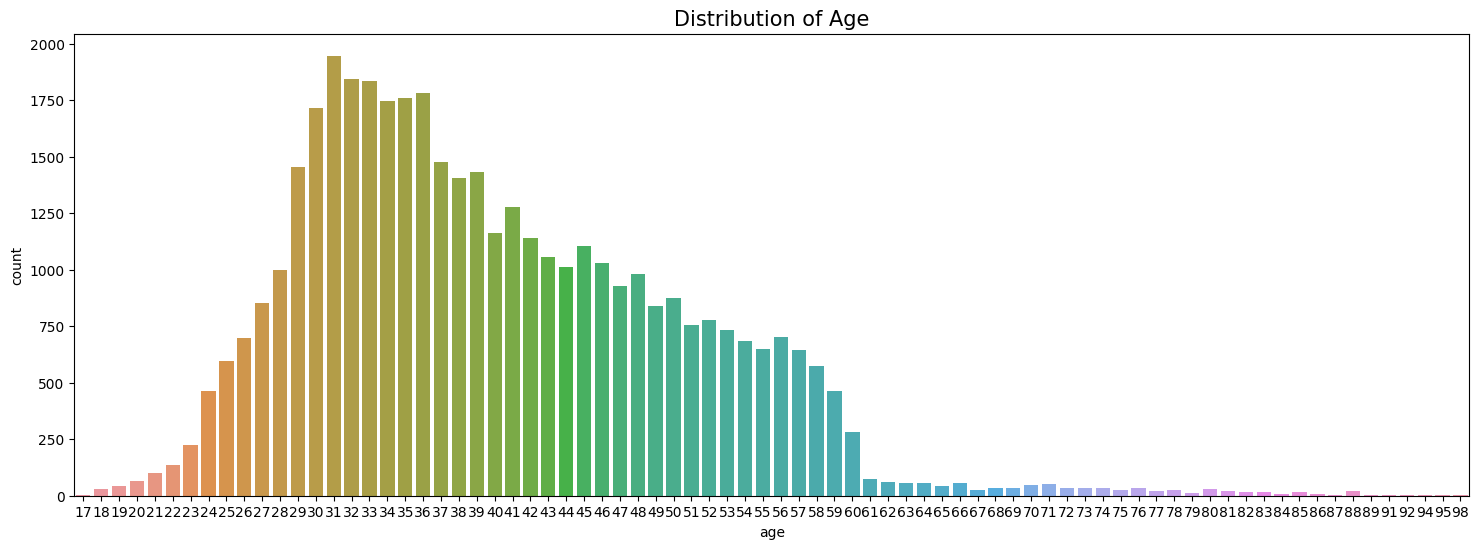

In [121]:
plt.figure(figsize = (18,6))
sns.countplot(x = 'age', data = df_client)
plt.title('Distribution of Age', fontsize = 15)
plt.show()

We can see that most of the clients age is around 20-40, where 75% of the observation age below 47. There are very few clients over the age of 70. These may present as outliers, we will further examin this age group later.

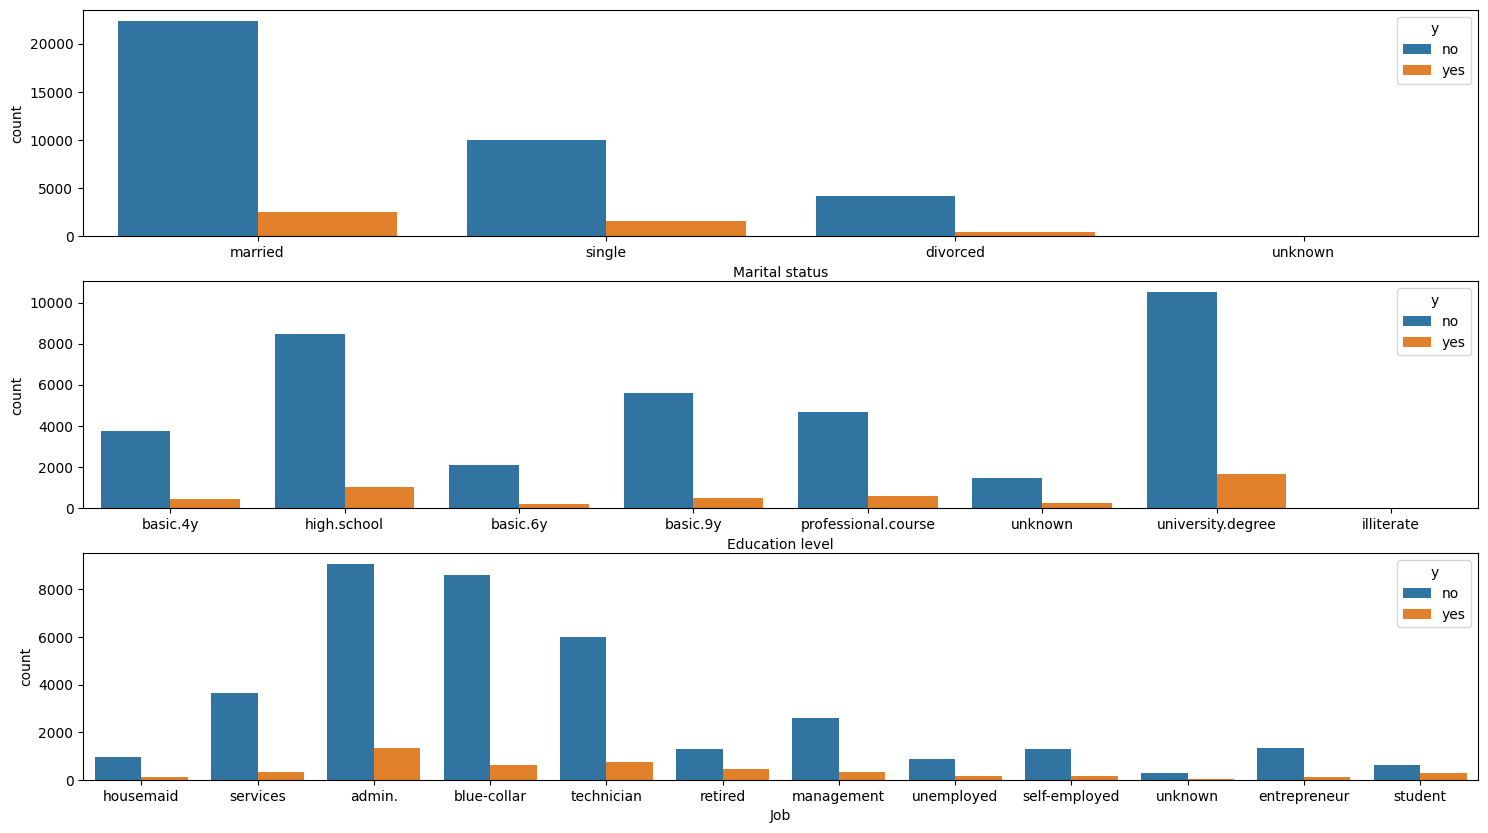

In [122]:
fig, axs = plt.subplots(3, 1,  figsize=(18, 10))

sns.countplot(x='marital', hue='y', data=df, ax=axs[0])
axs[0].set(xlabel="Marital status")

sns.countplot(x='education', hue='y', data=df, ax=axs[1])
axs[1].set(xlabel="Education level")

sns.countplot(x='job', hue='y', data=df, ax=axs[2])
axs[2].set(xlabel="Job")

plt.show()

### 2.2.2 Credit information

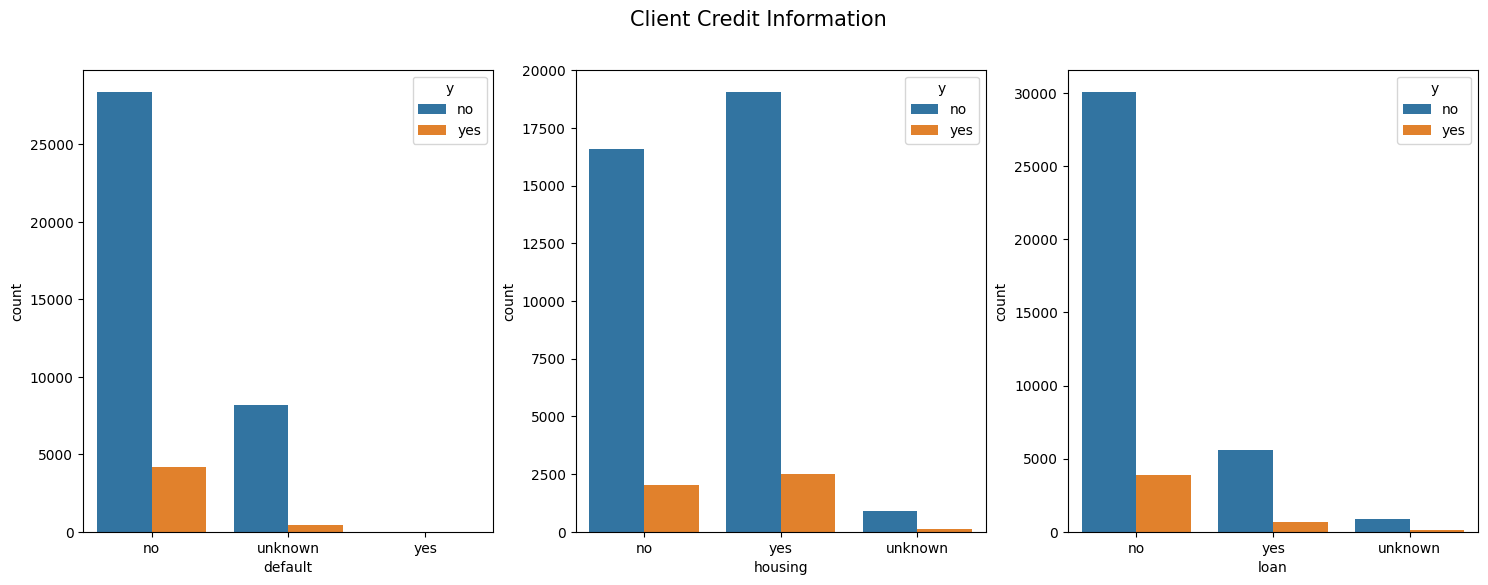

In [123]:
fig, axs = plt.subplots(1, 3,  figsize=(18, 6))
fig.suptitle('Client Credit Information', fontsize=15)

sns.countplot(x ='default', hue = 'y', data = df, ax=axs[0])
sns.countplot(x ='housing', hue = 'y', data = df, ax=axs[1])
sns.countplot(x ='loan', hue = 'y', data = df, ax=axs[2])
plt.show()

<a id="5"></a>
## 2.3 Last contact information
[Table of contents](#20)

In [124]:
df_contact = df.iloc[: , 7:11]
df_contact.columns

Index(['contact', 'month', 'day_of_week', 'duration'], dtype='object')

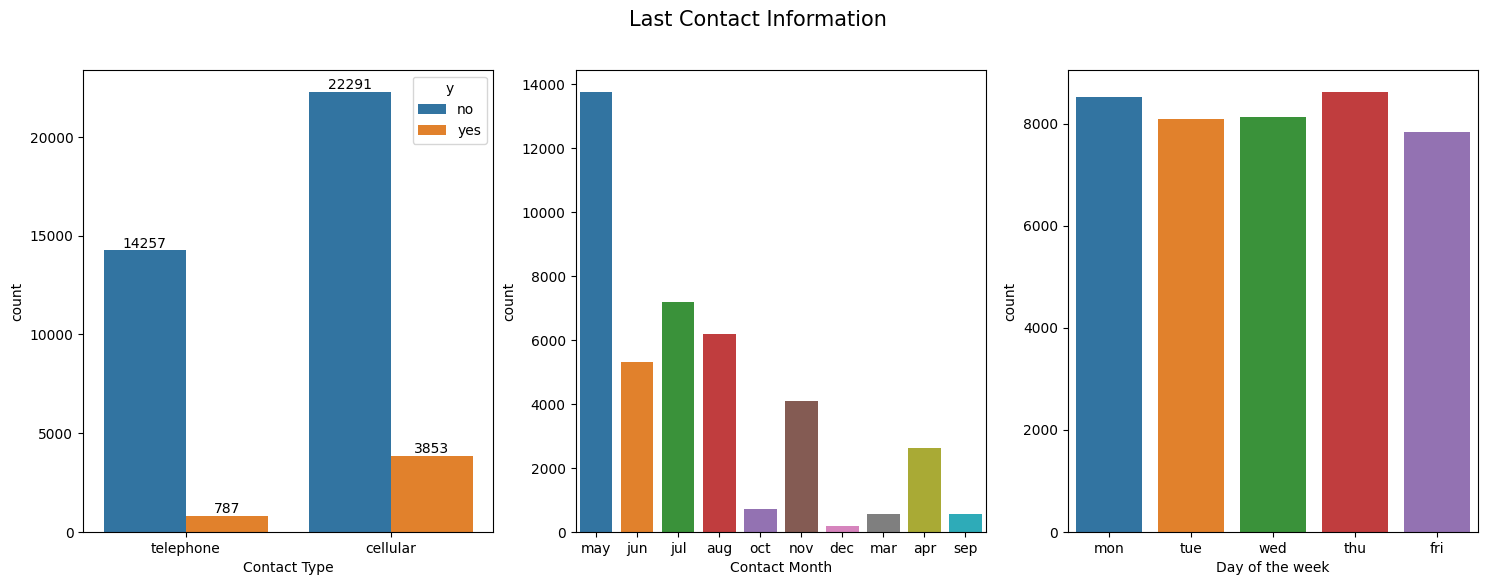

In [125]:
fig, axs = plt.subplots(1, 3,  figsize=(18, 6))
fig.suptitle('Last Contact Information', fontsize=15)

ax = sns.countplot(x ='contact', hue = 'y', data = df, ax=axs[0])
axs[0].set(xlabel="Contact Type")
for i in ax.containers:
    ax.bar_label(i,)

sns.countplot(x='month', data=df, ax=axs[1])
axs[1].set(xlabel="Contact Month")

sns.countplot(x='day_of_week', data=df, ax=axs[2])
axs[2].set(xlabel="Day of the week")
plt.show()

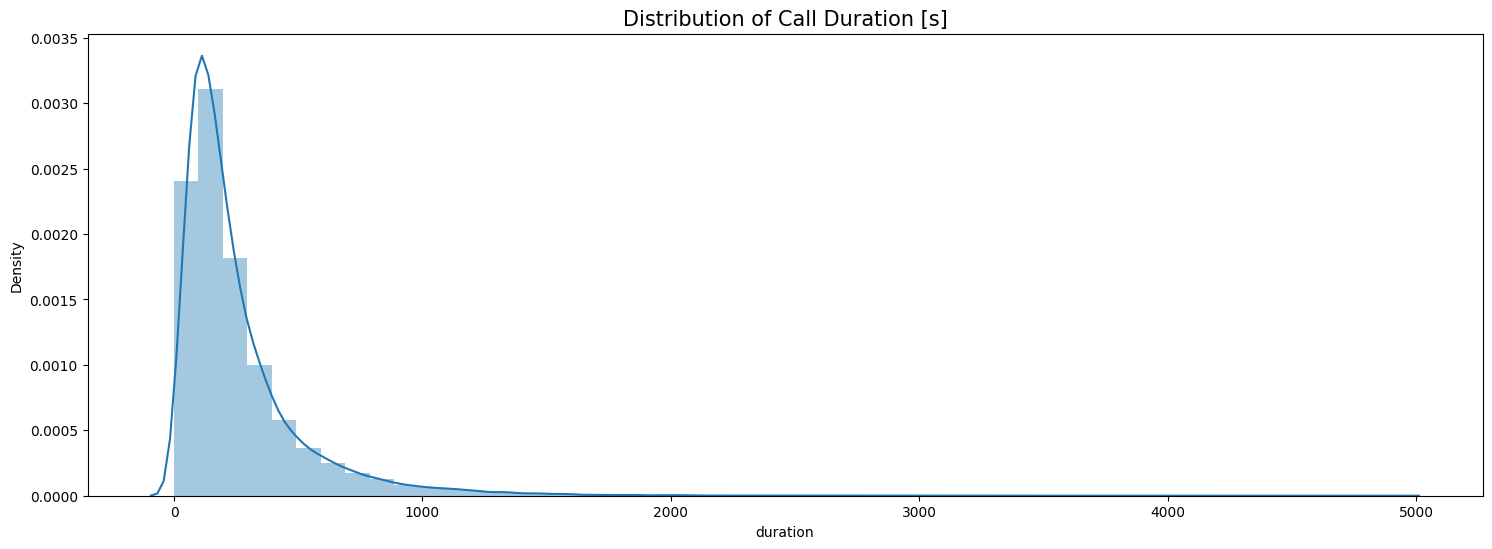

In [126]:
plt.figure(figsize = (18,6))
sns.distplot(df['duration'])
plt.title('Distribution of Call Duration [s]', fontsize = 15)
plt.show()

In [127]:
df_contact.describe()

,duration
count,41188.000000
mean,258.285010
std,259.279249
min,0.000000
25%,102.000000
50%,180.000000
75%,319.000000
max,4918.000000


Important note: 'duration' highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. 

This variable will be excluded in modelization step.

<a id="6"></a>
## 2.4 Other attributes
[Table of contents](#20)

In [4]:
df_other = df.loc[:, ['campaign', 'pdays','previous', 'poutcome']]
df_other.columns

Index(['campaign', 'pdays', 'previous', 'poutcome'], dtype='object')

In [129]:
df_other.describe()

,campaign,pdays,previous
count,41188.000000,41188.000000,41188.000000
mean,2.567593,962.475454,0.172963
std,2.770014,186.910907,0.494901
min,1.000000,0.000000,0.000000
25%,1.000000,999.000000,0.000000
50%,2.000000,999.000000,0.000000
75%,3.000000,999.000000,0.000000
max,56.000000,999.000000,7.000000


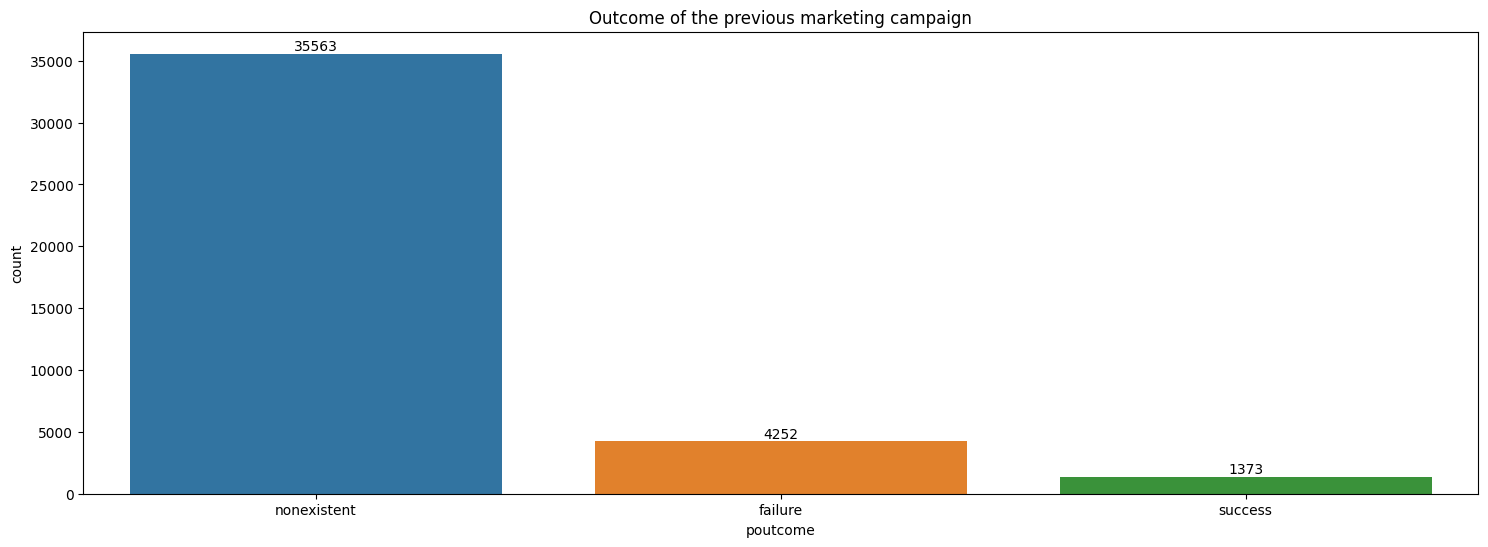

In [130]:
plt.figure(figsize = (18,6))
ax = sns.countplot(x='poutcome', data=df)
ax.set_title("Outcome of the previous marketing campaign")
for i in ax.containers:
    ax.bar_label(i,)

<a id="7"></a>
## 2.5 Social and economic context attributes
[Table of contents](#20)

In [131]:
df_social = df.loc[:, ['emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m','nr.employed']]
df_social

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.1,93.994,-36.4,4.857,5191.0
1,1.1,93.994,-36.4,4.857,5191.0
2,1.1,93.994,-36.4,4.857,5191.0
3,1.1,93.994,-36.4,4.857,5191.0
4,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...
41183,-1.1,94.767,-50.8,1.028,4963.6
41184,-1.1,94.767,-50.8,1.028,4963.6
41185,-1.1,94.767,-50.8,1.028,4963.6
41186,-1.1,94.767,-50.8,1.028,4963.6


- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric) 
- cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

Since they are all macro variables, the information remain the same for each individual at the time of recorded data. 

<a id="8"></a>
## 2.6 Features correlation
[Table of contents](#20)

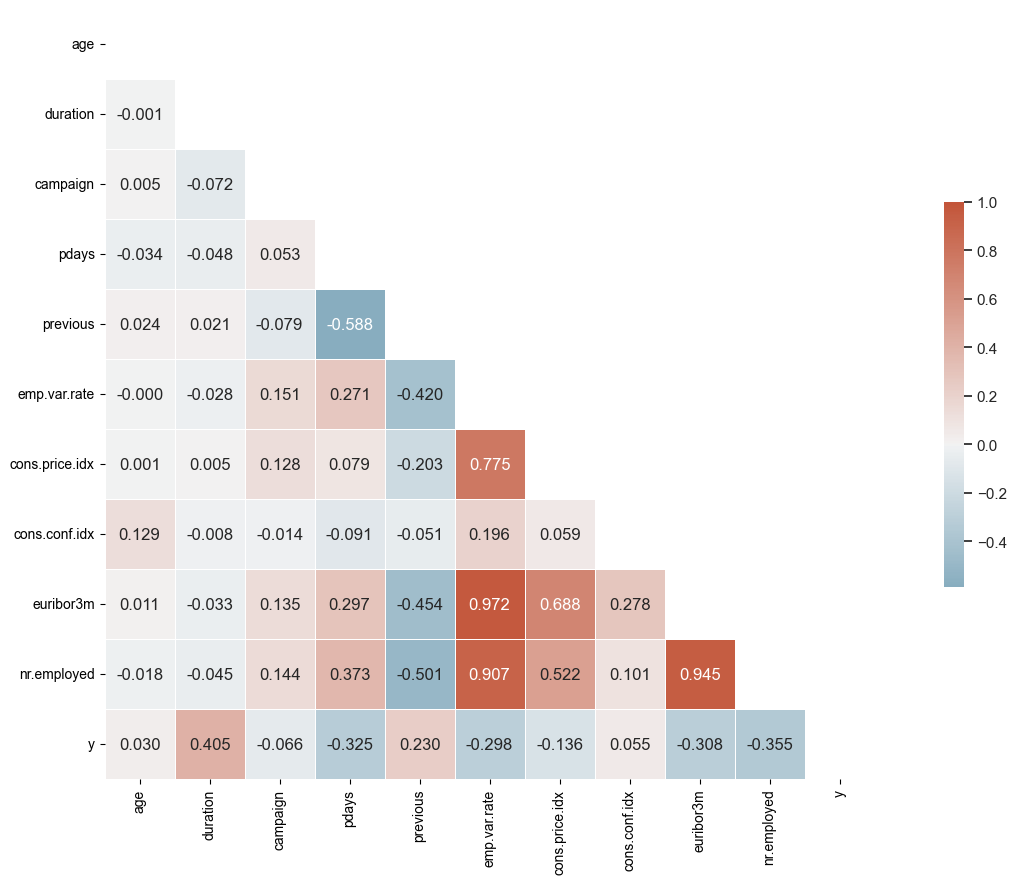

In [132]:
# Correlation Matrix
df1 = df.copy()
label = LabelEncoder()
df1['y'] = label.fit_transform(df1['y'])

f, ax = plt.subplots(figsize=(18, 10))
mat = df1.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set(font_scale=1.0)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True, fmt='.3f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

<a id="9"></a>
# 3. Data preprocessing
[Table of contents](#20)

3.1 [Outliers](#10) <br>
3.2 [Resampling](#11) <br>
3.3 [Dealing with categorical variables](#12) <br>
3.4 [Splitting data](#13) <br>
3.5 [Features scaling](#14) <br> 

<a id="10"></a>
## 3.1 Outliers

In [133]:
#Calculate the outliers:
  # Interquartile range, IQR = Q3 - Q1
  # lower 1.5*IQR whisker = Q1 - 1.5 * IQR 
  # Upper 1.5*IQR whisker = Q3 + 1.5 * IQR
    
print('Ages above: ',
      df_client['age'].quantile(q=0.75) + 
      1.5*(df_client['age'].quantile(q=0.75) - 
           df_client['age'].quantile(q=0.25)), 'are outliers')

Ages above:  69.5 are outliers


In [134]:
print('Numerber of outliers: ', df_client[df_client['age'] > 69.5]['age'].count())

Numerber of outliers:  469


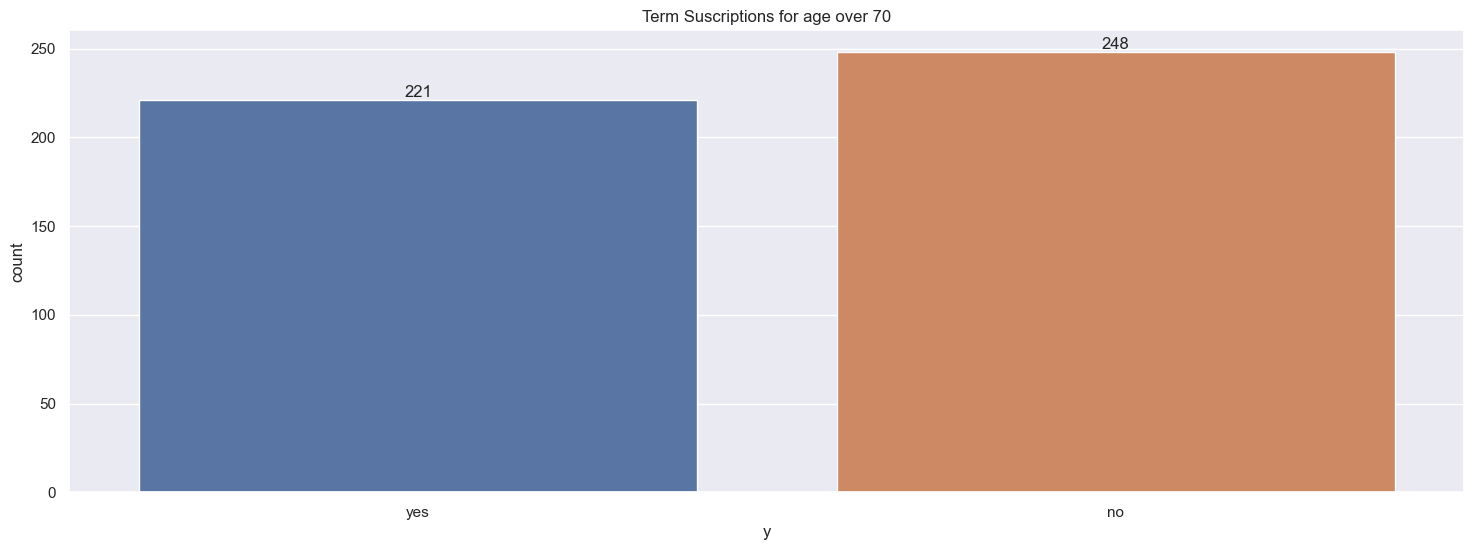

In [135]:
df_age70 = df[df['age'] > 69.5]

plt.figure(figsize = (18,6))
ax = sns.countplot(x='y', data=df_age70)
ax.set_title("Term Suscriptions for age over 70")
for i in ax.containers:
    ax.bar_label(i,)

- With the total number of ouliers (469 obs) compared to the total observation of 41188, it may not seem that much of a deal. One may consider removing them as it's only 1.14% of the whole dataset . Yet, if we take into account these ouliers with the target variable, we may suffer from potential imformation loss (about half of the clients age above 70 response positively to the marketing campaign). 
- We decided to keep these values by just keeping in mind that there exist some ouliers in 'age'.
- It may also exist some outliers in other numerical variables, yet most of them are not related to the individual but to time.

<a id="11"></a>
## 3.2 Resampling
[Table of contents](#20)

In dealing with the imbalanced dataset, we decided to do the random undersampling method as we have such large dataset and the number of the minority class is considerable for undersampling. Despite the possible data leakage, we still perform the undersampling before train-test split since the aim of this project is to get the most accurate model (rather than the most generalized model) in predicting the outcome for this given dataset.

In [5]:
## Resampling data with undersamppling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(df.iloc[:,:-1], df.y)

new_df = X_resampled.assign(y = y_resampled.values)
new_df.shape

(9280, 21)

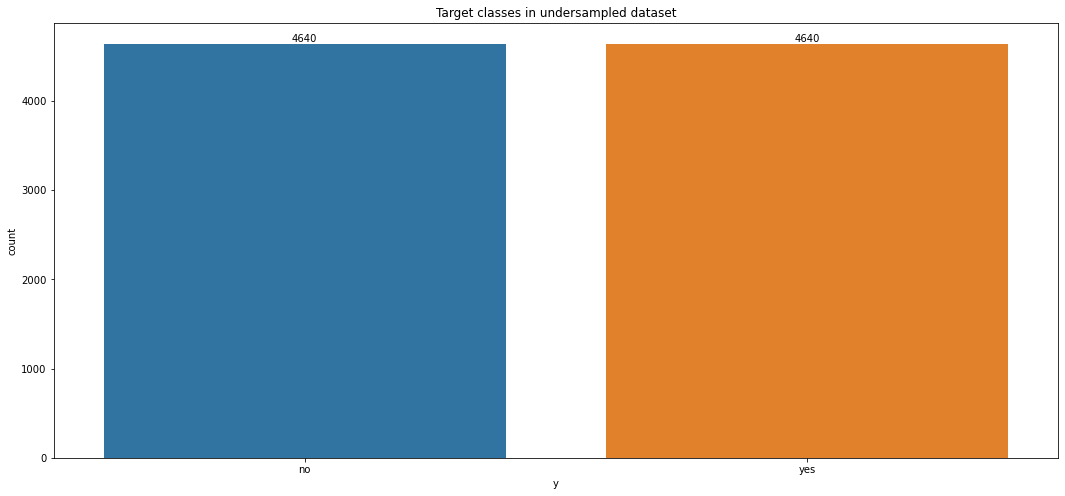

In [6]:
plt.figure(figsize = (18,8))
ax = sns.countplot(x='y', data=new_df)
ax.set_title("Target classes in undersampled dataset")
for i in ax.containers:
    ax.bar_label(i,)

<a id="12"></a>
## 3.3 Dealing with categorical variables
[Table of contents](#20)

In [7]:
# Source: https://towardsdatascience.com/encoding-categorical-variables-one-hot-vs-dummy-encoding-6d5b9c46e2db

# Creating new df (dropping 'duration')
new_df = new_df.drop('duration', axis=1)

# Label Encoding for target variable
label = LabelEncoder()
new_df['y'] = label.fit_transform(new_df['y'])

# Dummy Encoding for categorical features 
# 'drop_first=True : Dummy encoding
# 'drop_first=False : One-hot encoding
category_cols = new_df.select_dtypes(['object'])

for col in category_cols:
    new_df = pd.concat([new_df.drop(col, axis=1),
                        pd.get_dummies(new_df[col], prefix=col, prefix_sep='_',
                                       drop_first=True, dummy_na=False)], axis=1)
    
new_df.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,24,2,999,0,1.1,93.994,-36.4,4.858,5191.0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,37,2,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
2,44,6,12,1,-1.8,92.893,-46.2,1.354,5099.1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
3,33,1,999,0,-1.8,92.893,-46.2,1.291,5099.1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
4,40,2,999,0,-1.8,92.893,-46.2,1.281,5099.1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0


<a id="13"></a>
## 3.4 Splitting data
[Table of contents](#20)

In [8]:
X = new_df.drop('y', axis=1)
y = new_df.y

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)
print("X_train: ",X_train.shape)
print("X_test:  ",X_test.shape)
print("y_train: ",y_train.shape)
print("y_test:  ",y_test.shape)

X_train:  (7424, 51)
X_test:   (1856, 51)
y_train:  (7424,)
y_test:   (1856,)


<a id="14"></a>
## 3.5 Features scaling
[Table of contents](#20)

In [9]:
# Features scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<a id="15"></a>
# 4. Modelling
[Table of contents](#20) <br> 

4.1 [Logistic Regression](#16) <br>
4.2 [SVM Classifier](#17) <br>
4.3 [ANN](#18) 

<a id="16"></a>
## 4.1 Logistic Regression

In [10]:
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
lgr_pred = lgr.predict(X_test)

print('F1 Score: {:.5f}'.format(f1_score(y_test, lgr_pred)))
print('ROC-AUC Score: {:.5f}'.format(roc_auc_score(y_test, lgr_pred)))
print('Accuracy Score: {:.5f}'.format(accuracy_score(y_test, lgr_pred)))

F1 Score: 0.69988
ROC-AUC Score: 0.73571
Accuracy Score: 0.73384


In [11]:
print(classification_report(y_test, lgr_pred, digits=5))

              precision    recall  f1-score   support

           0    0.68229   0.85996   0.76089       914
           1    0.81818   0.61146   0.69988       942

    accuracy                        0.73384      1856
   macro avg    0.75024   0.73571   0.73038      1856
weighted avg    0.75126   0.73384   0.72992      1856



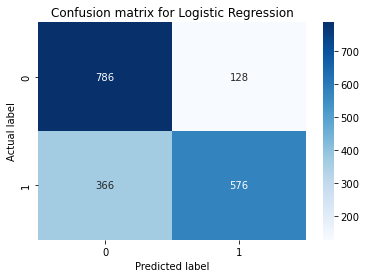

In [16]:
lgr_cm = confusion_matrix(y_test, lgr_pred)
p = sns.heatmap(lgr_cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion matrix for Logistic Regression')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

<a id="17"></a>
## 4.2 SVM Classifier
[Table of contents](#20)

In [13]:
# Base model with default rbf kenel 
svc = SVC(random_state=42)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

print('F1 Score: {:.5f}'.format(f1_score(y_test, svc_pred)))
print('ROC-AUC Score: {:.5f}'.format(roc_auc_score(y_test, svc_pred)))
print('Accuracy Score: {:.5f}'.format(accuracy_score(y_test, svc_pred)))

F1 Score: 0.69165
ROC-AUC Score: 0.73155
Accuracy Score: 0.72953


In [14]:
# Polynomial kenel
svc_poly = SVC(kernel='poly', random_state=42)
svc_poly.fit(X_train, y_train)
svc_poly_pred = svc_poly.predict(X_test)

print('F1 Score: {:.5f}'.format(f1_score(y_test, svc_poly_pred)))
print('ROC-AUC Score: {:.5f}'.format(roc_auc_score(y_test, svc_poly_pred)))
print('Accuracy Score: {:.5f}'.format(accuracy_score(y_test, svc_poly_pred)))

F1 Score: 0.68719
ROC-AUC Score: 0.72834
Accuracy Score: 0.72629


In [15]:
# Linear kenel
svc_linear = SVC(kernel='linear', random_state=42)
svc_linear.fit(X_train, y_train)
svc_linear_pred = svc_linear.predict(X_test)

print('F1 Score: {:.5f}'.format(f1_score(y_test, svc_linear_pred)))
print('ROC-AUC Score: {:.5f}'.format(roc_auc_score(y_test, svc_linear_pred)))
print('Accuracy Score: {:.5f}'.format(accuracy_score(y_test, svc_linear_pred)))

F1 Score: 0.68473
ROC-AUC Score: 0.72619
Accuracy Score: 0.72414


In [16]:
# https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/

# hyperparameter tuning for rbf kernel
param_grid = {'C': [1,10,100,1000], 'gamma': [0.01,0.02,0.05,0.1,0.5,1]}

svc = SVC(random_state=42)
svc_grid = GridSearchCV(svc, param_grid, cv=5, verbose=0)

svc_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.01, 0.02, 0.05, 0.1, 0.5, 1]})

In [17]:
print(svc_grid.best_estimator_)

SVC(C=1, gamma=0.02, random_state=42)


In [18]:
print(svc_grid.best_score_)

0.746228048680879


In [17]:
# Predicting with final SVC
svc = SVC(C=1, gamma=0.02, random_state=42, probability=True) #get probab. for roc curve
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

print('F1 Score: {:.5f}'.format(f1_score(y_test, svc_pred)))
print('ROC-AUC Score: {:.5f}'.format(roc_auc_score(y_test, svc_pred)))
print('Accuracy Score: {:.5f}'.format(accuracy_score(y_test, svc_pred)))

F1 Score: 0.69165
ROC-AUC Score: 0.73155
Accuracy Score: 0.72953


In [18]:
print('Training score: {:.5f}'.format(svc.score(X_train, y_train)))
print('Test score: {:.5f}'.format(svc.score(X_test, y_test)))

Training score: 0.76387
Test score: 0.72953




It turns out that our base model with rbf kenel was already the best model!

In [19]:
# Classification report on final SVC
print(classification_report(y_test, svc_pred, digits=5))

              precision    recall  f1-score   support

           0    0.67607   0.86543   0.75912       914
           1    0.82070   0.59766   0.69165       942

    accuracy                        0.72953      1856
   macro avg    0.74838   0.73155   0.72538      1856
weighted avg    0.74948   0.72953   0.72487      1856



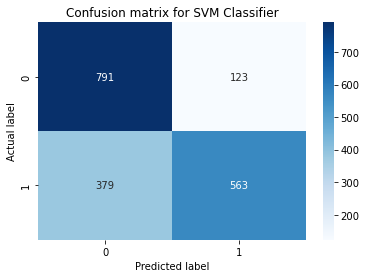

In [21]:
# Confusion matrix
svc_cm = confusion_matrix(y_test, svc_pred)
p = sns.heatmap(pd.DataFrame(svc_cm), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix for SVM Classifier')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

<a id="18"></a>
## 4.3 ANN
[Table of contents](#20)

We first define a sequentially connected network with three layers. To define the fully connected layer use the Dense class of Keras:
- The first layer with 51 inputs and activation function as relu
- The hidden layer with 25 neurons (follow the simplest rule of thumb: N.input/2)
- Finally, at the output layer, we use 1 unit and activation as sigmoid because it is a binary classification problem.

In compiling the model we must specify some additional parameters to better evaluate the model and to find the best set of weights to map inputs to outputs.
- Loss Function – one must specify the loss function to evaluate the set of weights on which model will be mapped. We will use cross-entropy as a loss function under the name of 'binary_crossentropy' which is used for binary classification.
- Optimizer – used to optimize the loss. We will use 'adam' which is a popular version of gradient descent and gives the best result in most problems.

In [ ]:
# Defining the network
#model = Sequential()
#model.add(Dense(units = 25, activation = 'relu', input_dim = 51))
#model.add(Dense(units = 25, activation = 'relu'))
#model.add(Dense(units = 1, activation = 'sigmoid'))
#model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [90]:
#https://www.kaggle.com/code/shrutimechlearn/deep-tutorial-1-ann-and-classification

# Model building function
def build_model():
    model = Sequential()
    model.add(Dense(units = 25, activation = 'relu', input_dim = 51))
    model.add(Dense(units = 25, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [91]:
# Fitting the model
model = KerasClassifier(build_fn = build_model,
                        batch_size = 10, epochs = 100, verbose=0)

model.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0)

KerasClassifier(
	model=None
	build_fn=<function build_model at 0x0000016ED9264430>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	class_weight=None
)

In [92]:
# Accuracy score on 10folds CV 
acc_CV = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
mean = acc_CV.mean()
variance = acc_CV.std()

In [93]:
print('Train set CV: \n')
print('Accuracy mean: {:.5f}'.format(mean))
print('Accuracy deviation: {:.5f}'.format(variance))

Train set CV: 

Accuracy mean: 0.67363
Accuracy deviation: 0.02069


In [129]:
# Predicting on test set 
y_pred = model.predict(X_test)

print('Test set results: \n')
print('F1 Score: {:.5f}'.format(f1_score(y_test, y_pred)))
print('ROC-AUC Score: {:.5f}'.format(roc_auc_score(y_test, y_pred)))
print('Accuracy Score: {:.5f}'.format(accuracy_score(y_test, y_pred)))

Test set results: 

F1 Score: 0.66254
ROC-AUC Score: 0.67808
Accuracy Score: 0.67726


In [85]:
# Tuning with GridSearchCV
model = KerasClassifier(build_fn = build_model)
parameters = {'batch_size': [10, 20, 30, 50],
              'epochs': [100, 150, 200]}

model_grid = GridSearchCV(estimator = model,
                          param_grid = parameters,
                          scoring = 'accuracy',
                          cv = 5, n_jobs = -1)

model_grid = model_grid.fit(X_train, y_train, verbose = 0)

In [89]:
# https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

# summarize results
print("Best: %f using %s" % (model_grid.best_score_, model_grid.best_params_))
means = model_grid.cv_results_['mean_test_score']
stds = model_grid.cv_results_['std_test_score']
params = model_grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.699489 using {'batch_size': 50, 'epochs': 100} /n
0.666220 (0.013719) with: {'batch_size': 10, 'epochs': 100}
0.671473 (0.009030) with: {'batch_size': 10, 'epochs': 150}
0.666490 (0.014819) with: {'batch_size': 10, 'epochs': 200}
0.671739 (0.006997) with: {'batch_size': 20, 'epochs': 100}
0.665816 (0.009836) with: {'batch_size': 20, 'epochs': 150}
0.664467 (0.003112) with: {'batch_size': 20, 'epochs': 200}
0.683324 (0.005481) with: {'batch_size': 30, 'epochs': 100}
0.674434 (0.003481) with: {'batch_size': 30, 'epochs': 150}
0.671874 (0.007042) with: {'batch_size': 30, 'epochs': 200}
0.699489 (0.003130) with: {'batch_size': 50, 'epochs': 100}
0.682649 (0.009580) with: {'batch_size': 50, 'epochs': 150}
0.672144 (0.010606) with: {'batch_size': 50, 'epochs': 200}


In [155]:
# Fitting the final model 
ann_grid = KerasClassifier(build_fn = build_model,
                             batch_size = 50, epochs = 100, verbose=0)

ann_grid = ann_grid.fit(X_train, y_train, verbose = 0)
ann_pred = ann_grid.predict(X_test)

print('F1 Score: {:.5f}'.format(f1_score(y_test, ann_pred)))
print('ROC-AUC Score: {:.5f}'.format(roc_auc_score(y_test, ann_pred)))
print('Accuracy Score: {:.5f}'.format(accuracy_score(y_test, ann_pred)))

F1 Score: 0.67980
ROC-AUC Score: 0.69423
Accuracy Score: 0.69343


In [156]:
# Classification report on final ANN
print(classification_report(y_test, ann_pred, digits=5))

              precision    recall  f1-score   support

           0    0.66895   0.74726   0.70594       914
           1    0.72335   0.64119   0.67980       942

    accuracy                        0.69343      1856
   macro avg    0.69615   0.69423   0.69287      1856
weighted avg    0.69656   0.69343   0.69267      1856



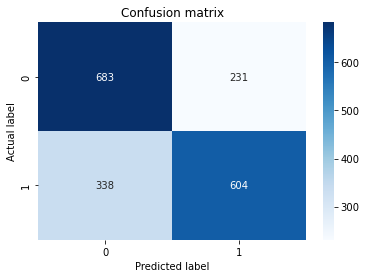

In [157]:
# Confusion matrix
ann_cm = confusion_matrix(y_test, ann_pred)
p = sns.heatmap(pd.DataFrame(ann_cm), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

<a id="19"></a>
# 5. Results summary
[Table of contents](#20)

In [158]:
# Classification Report of the 3 model
print('Classification Report: \n')
print('1. Logistic Regression: \n')
print(classification_report(y_test, lgr_pred, digits=5))
print('2. SVM Classifier: \n')
print(classification_report(y_test, svc_pred, digits=5))
print('3. Neural Network: \n')
print(classification_report(y_test, ann_pred, digits=5))

Classification Report: 

1. Logistic Regression: 

              precision    recall  f1-score   support

           0    0.68229   0.85996   0.76089       914
           1    0.81818   0.61146   0.69988       942

    accuracy                        0.73384      1856
   macro avg    0.75024   0.73571   0.73038      1856
weighted avg    0.75126   0.73384   0.72992      1856

2. SVM Classifier: 

              precision    recall  f1-score   support

           0    0.67607   0.86543   0.75912       914
           1    0.82070   0.59766   0.69165       942

    accuracy                        0.72953      1856
   macro avg    0.74838   0.73155   0.72538      1856
weighted avg    0.74948   0.72953   0.72487      1856

3. Neural Network: 

              precision    recall  f1-score   support

           0    0.66895   0.74726   0.70594       914
           1    0.72335   0.64119   0.67980       942

    accuracy                        0.69343      1856
   macro avg    0.69615   0.69423  

In [159]:
# ROC-AUC Scores
print('ROC-AUC Score: \n')
print('1. Logistic Regression: {:.5f}'.format(roc_auc_score(y_test, lgr_pred)))
print('2. SVM Classifier: {:.5f}'.format(roc_auc_score(y_test, svc_pred)))
print('3. Neural Network: {:.5f}'.format(roc_auc_score(y_test, ann_pred)))

ROC-AUC Score: 

1. Logistic Regression: 0.73571
2. SVM Classifier: 0.73155
3. Neural Network: 0.69423


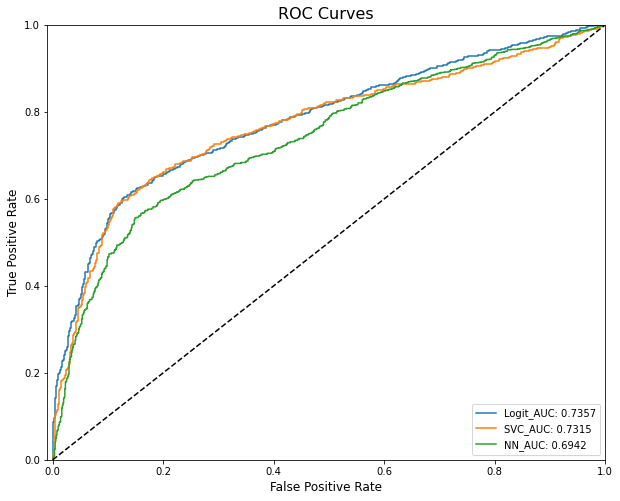

In [161]:
# ROC Curve
from sklearn.metrics import roc_curve

lgr_pred_proba = lgr.predict_proba(X_test)[:,1]
svc_pred_proba = svc.predict_proba(X_test)[:,1]
nn_pred_proba = ann_grid.predict_proba(X_test)[:,1]

lgr_fpr, lgr_tpr, lgr_thresold = roc_curve(y_test, lgr_pred_proba)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, svc_pred_proba)
nn_fpr, nn_tpr, nn_threshold = roc_curve(y_test, nn_pred_proba)

def graph_roc_curve_multiple(lgr_fpr, lgr_tpr, svc_fpr, svc_tpr, nn_fpr, nn_tpr):
    plt.figure(figsize=(10,8))
    plt.title('ROC Curves', fontsize=16)
    plt.plot(lgr_fpr, lgr_tpr, label='Logit_AUC: {:.4f}'.format(roc_auc_score(y_test, lgr_pred)))
    plt.plot(svc_fpr, svc_tpr, label='SVC_AUC: {:.4f}'.format(roc_auc_score(y_test, svc_pred)))
    plt.plot(nn_fpr, nn_tpr, label='NN_AUC: {:.4f}'.format(roc_auc_score(y_test, ann_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(loc="lower right")
    
graph_roc_curve_multiple(lgr_fpr, lgr_tpr, svc_fpr, svc_tpr, nn_fpr, nn_tpr)
plt.show()

### References:

- Dataset: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
- 7 Techniques to Handle Imbalanced Data: https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html
- Build your first Neural Network model using Keras:<br> https://www.analyticsvidhya.com/blog/2021/05/develop-your-first-deep-learning-model-in-python-with-keras/
- Kaggle Notebooks:
    - [Bank Marketing + Classification + ROC,F1,RECALL...](https://www.kaggle.com/code/henriqueyamahata/bank-marketing-classification-roc-f1-recall)
    - [Credit Fraud || Dealing with Imbalanced Datasets](https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets)
    - [SVM Classifier Tutorial](https://www.kaggle.com/code/prashant111/svm-classifier-tutorial)
    - [Deep Learning Tutorial for Beginners](https://www.kaggle.com/code/kanncaa1/deep-learning-tutorial-for-beginners)